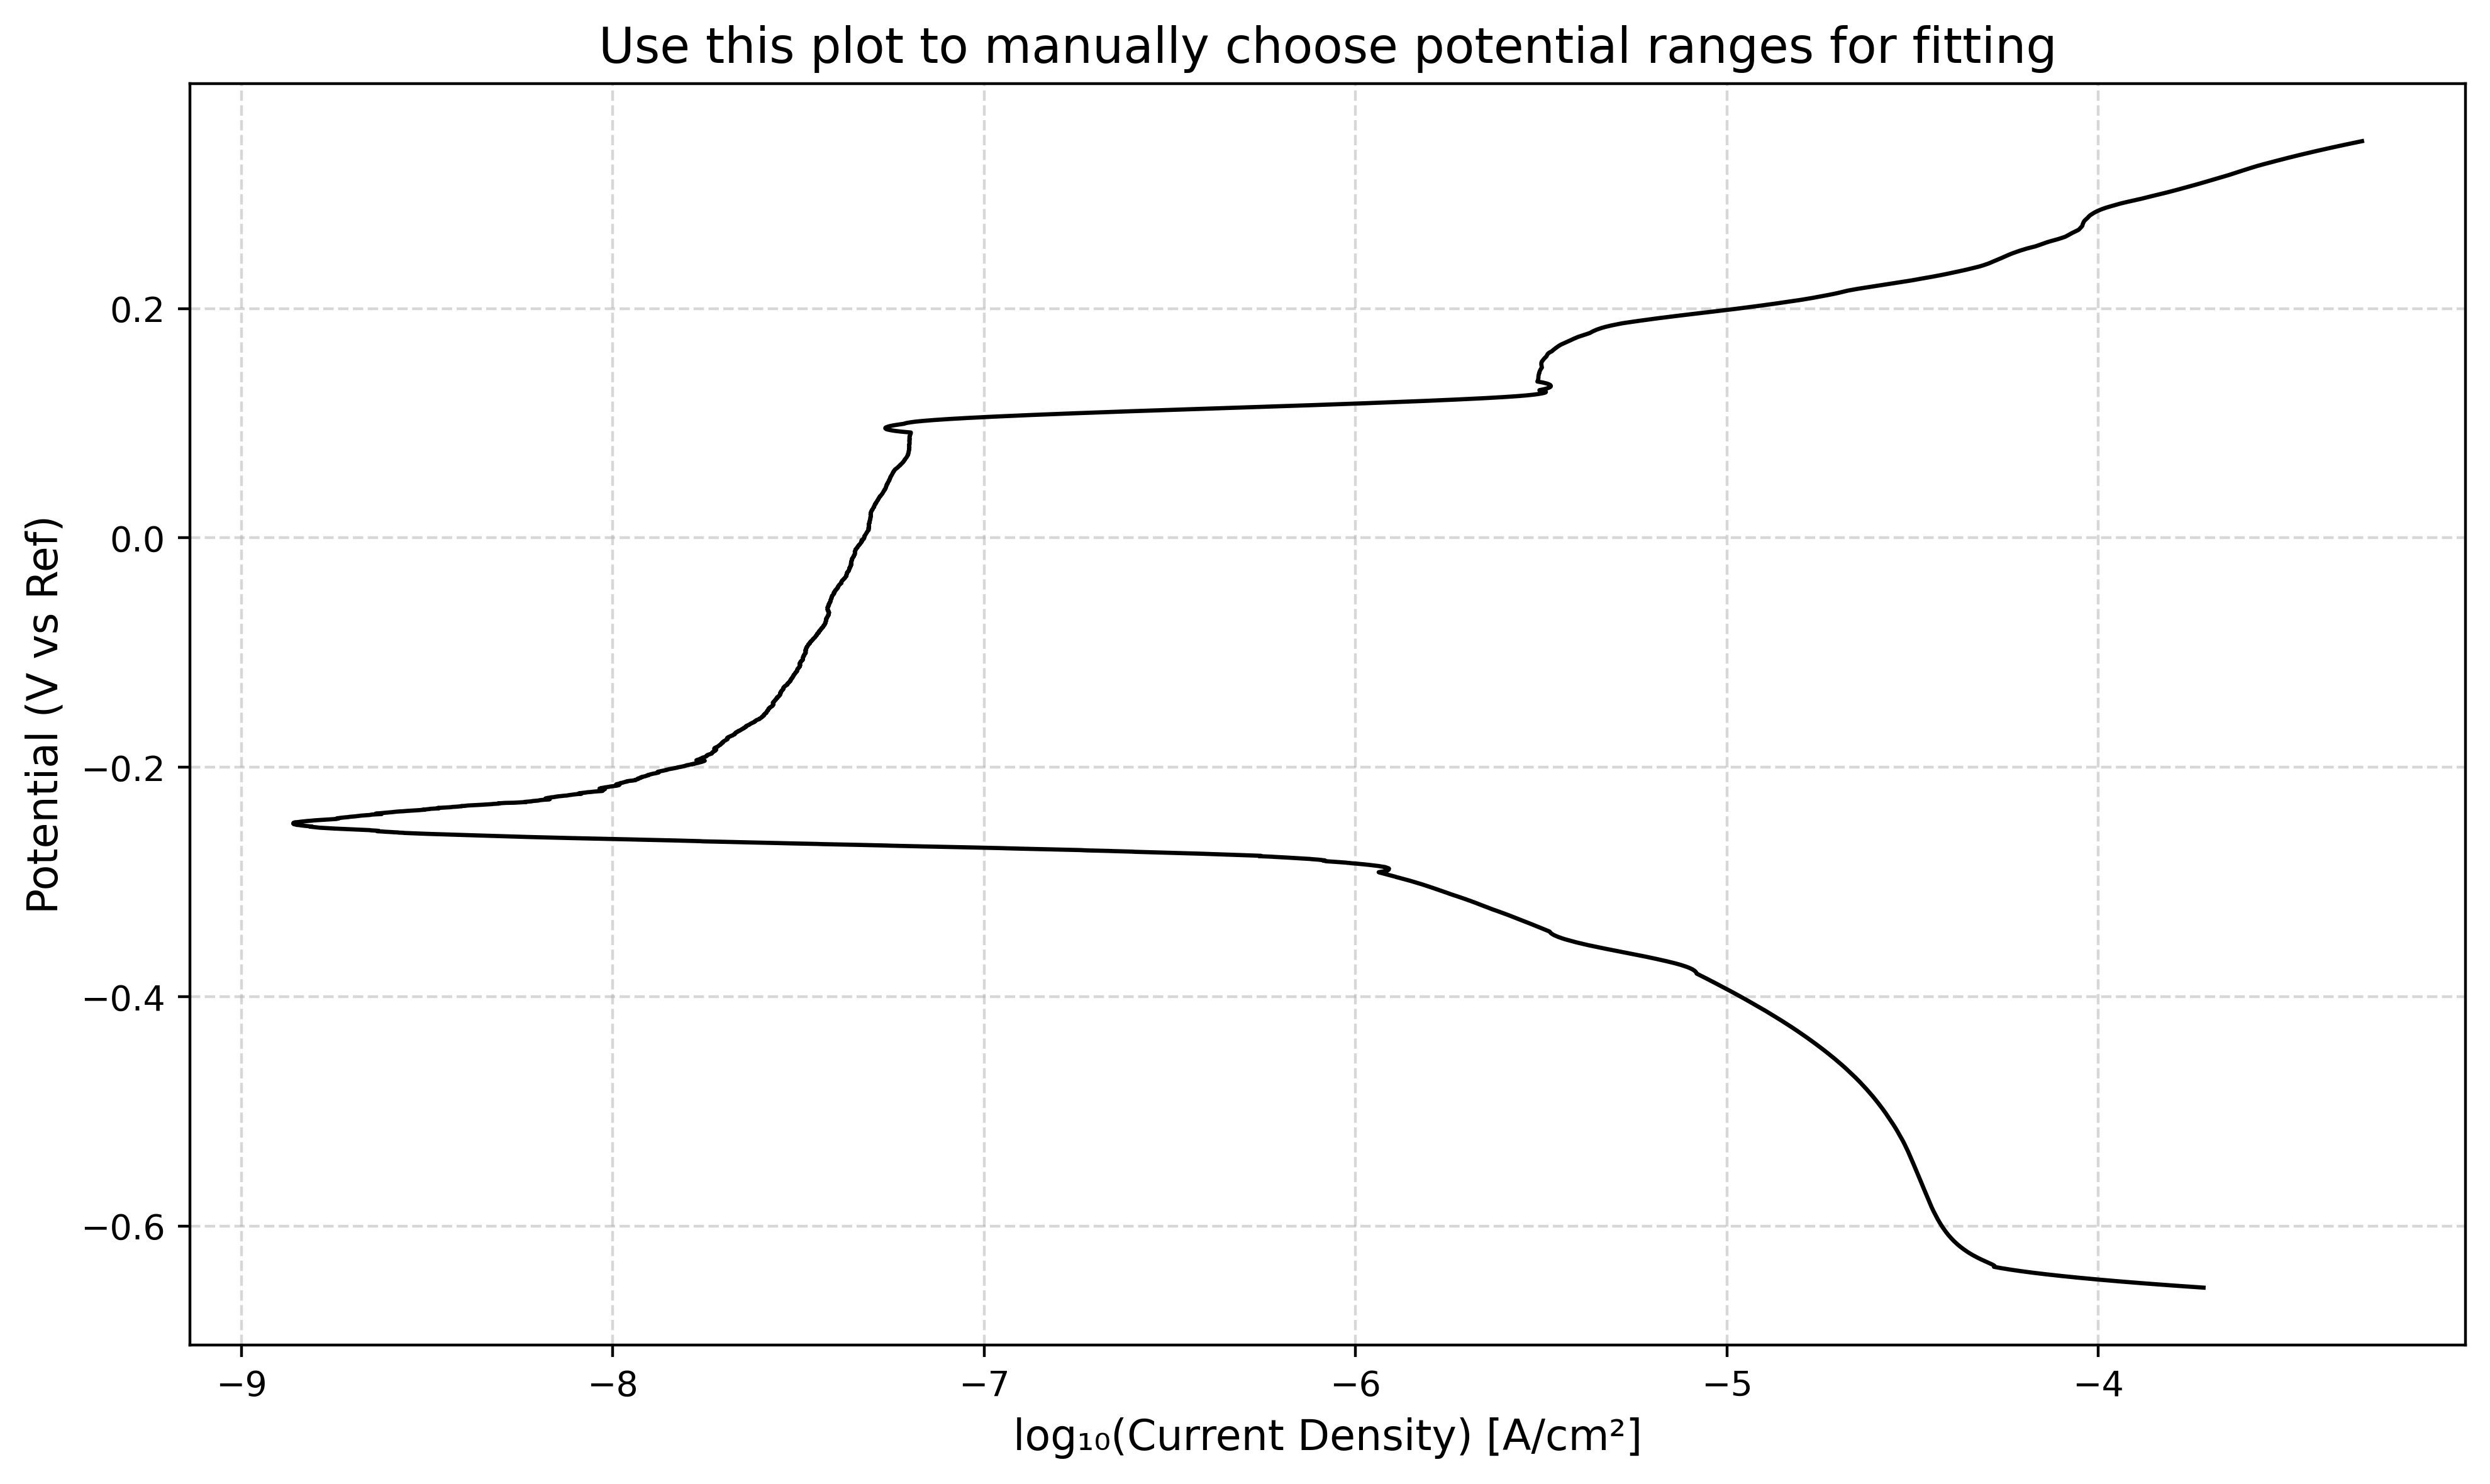

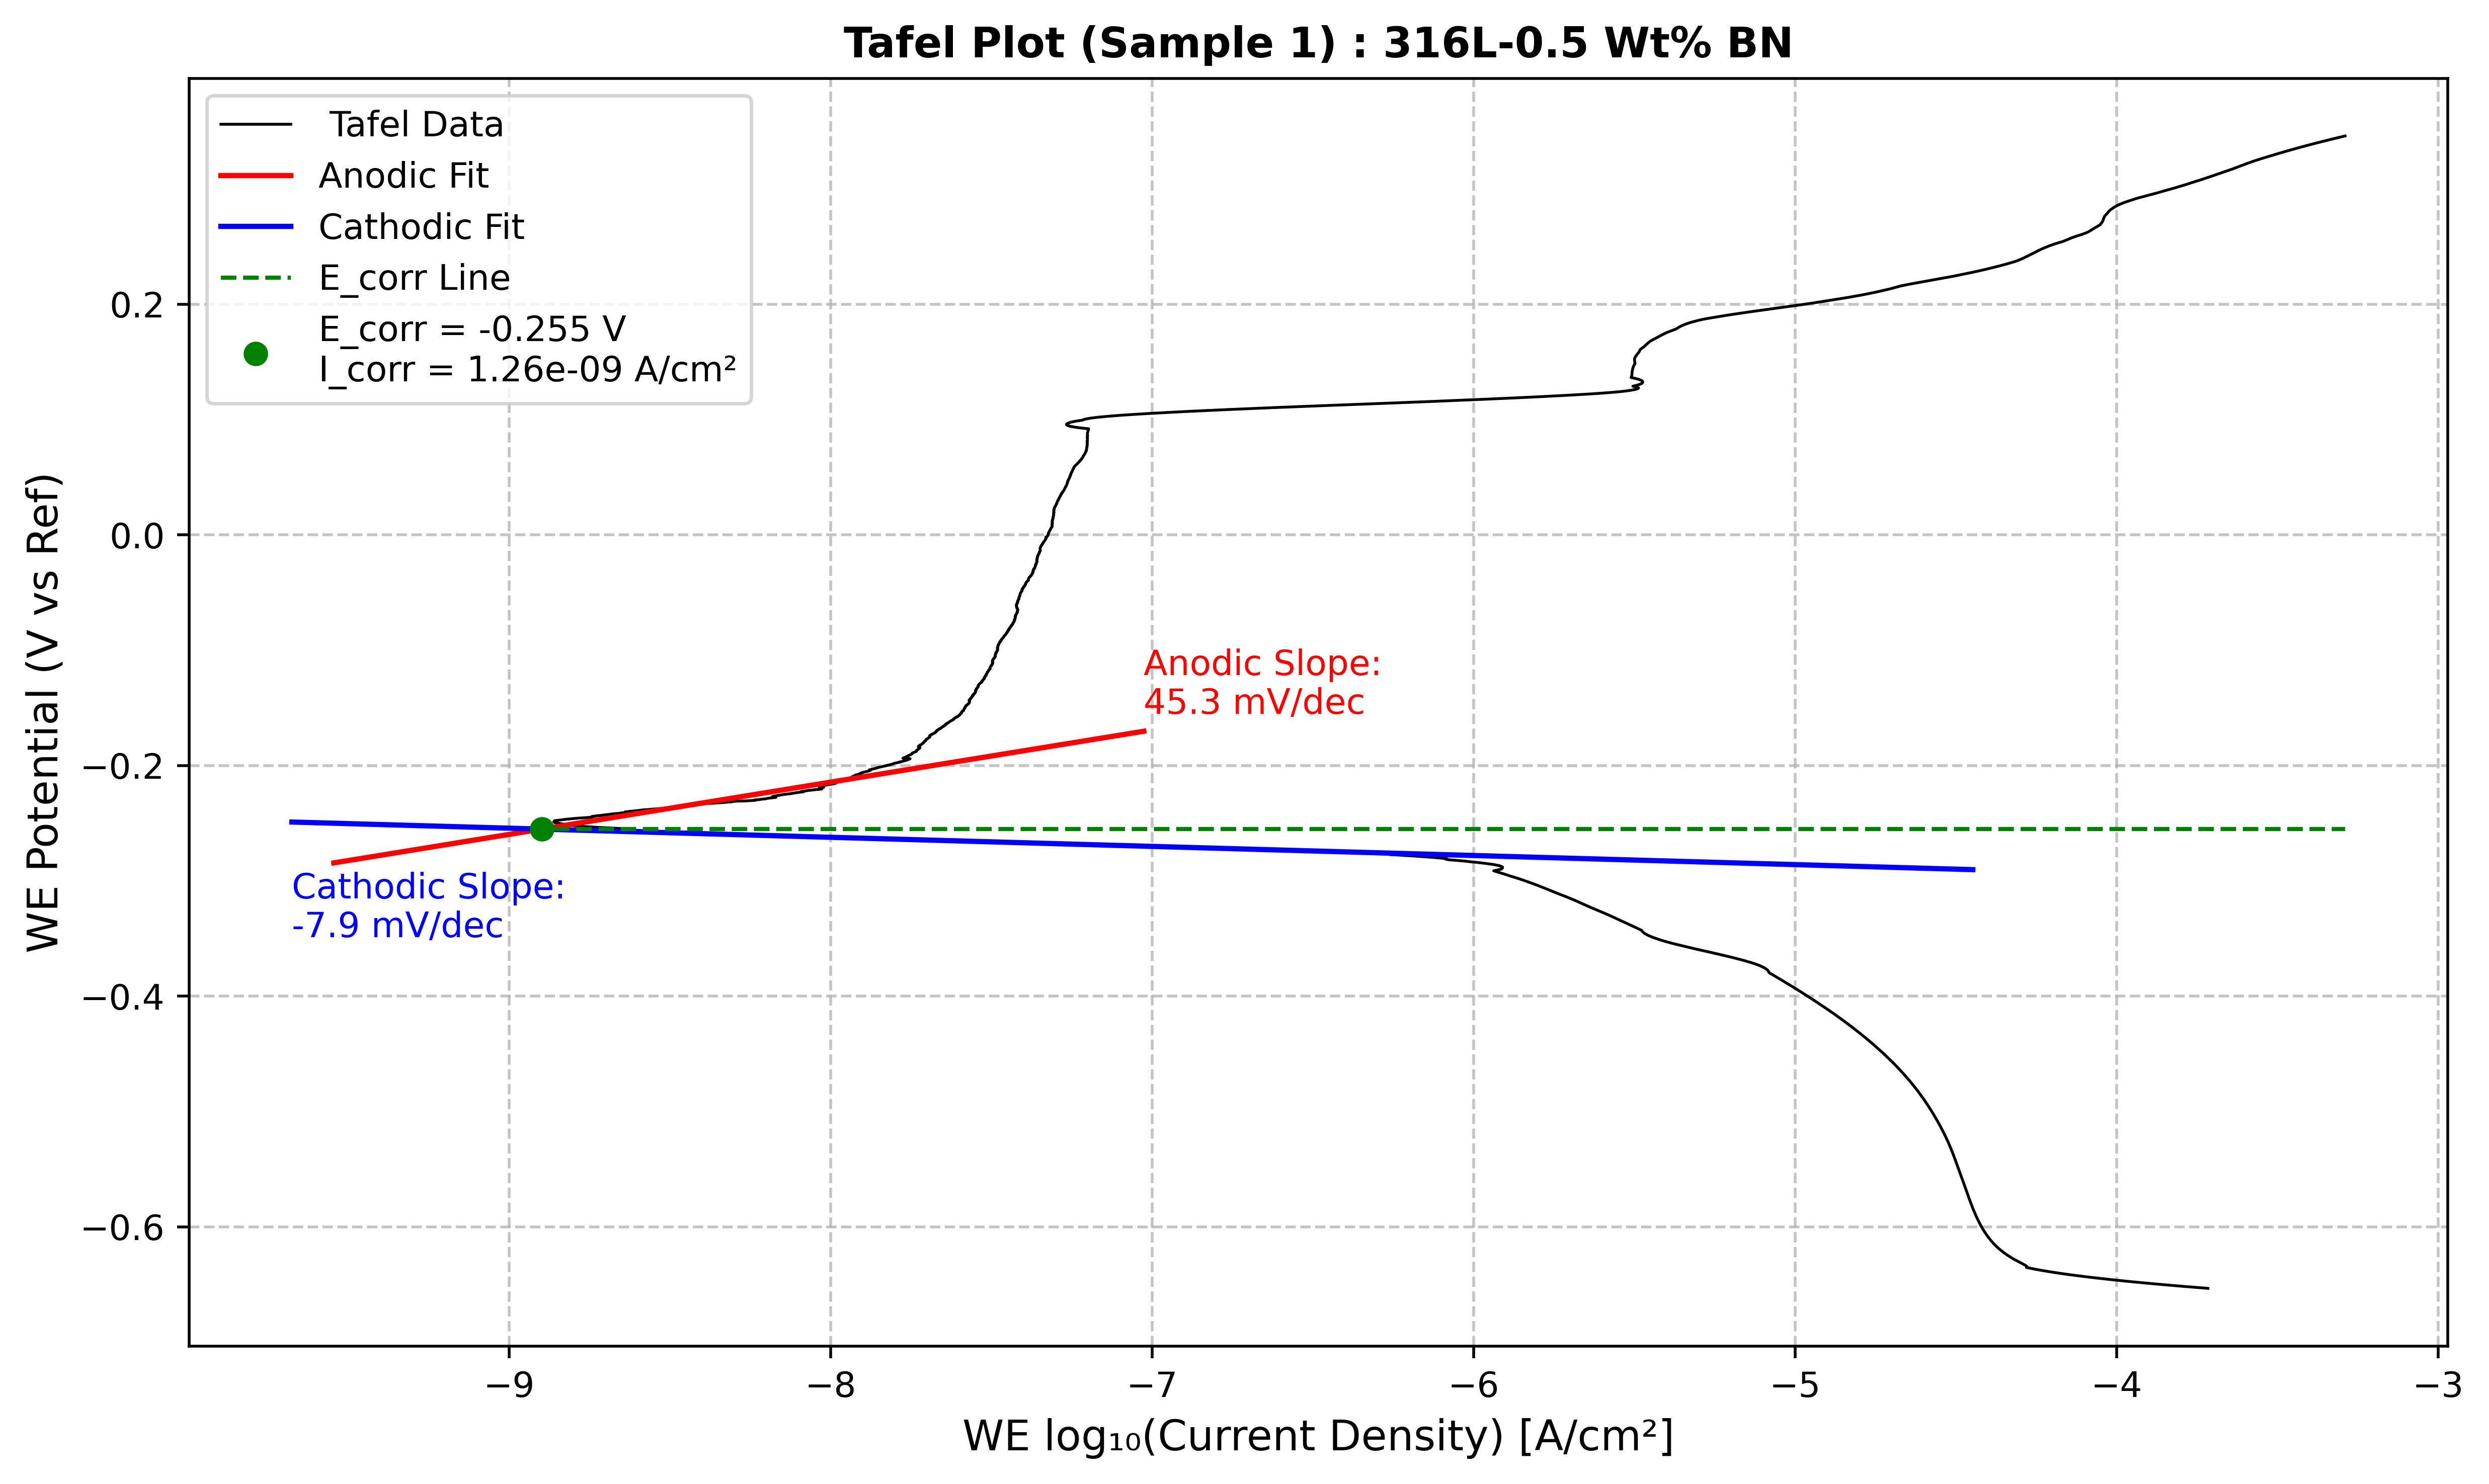


=== Tafel Results ===
Anodic Tafel Slope   : 45.32 mV/dec
Cathodic Tafel Slope : -7.90 mV/dec
E_corr               : -0.255 V
I_corr               : 1.26e-09 A/cm²


In [ ]:
#For a noisy data and current spikes removal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import linregress, zscore

# === Load and prepare data ===
df = pd.read_csv("0.5(1st).csv", encoding="ISO-8859-1")#enter your file name here
potential_col = 'Potential'
current_col = 'log j'

# Remove zero current values
df = df[df[current_col] != 0].copy()
df['log_current_density'] = df[current_col] 

#  1. Outlier removal on potential using Z-score
z_scores = zscore(df[potential_col])
df = df[np.abs(z_scores) < 2]  # Keep only values within 3 standard deviations

#  2. Apply Savitzky-Golay filter to smooth potential
df['filtered_potential'] = savgol_filter(df[potential_col], window_length=997, polyorder=2) #window length should always be odd and adjusted accordingly

#gaussian filter
from scipy.ndimage import gaussian_filter1d
df['gaussian_filtered'] = gaussian_filter1d(df[potential_col], sigma=10)
from scipy.signal import medfilt
df['median_filtered'] = medfilt(df[potential_col], kernel_size=11)



#  Plot filtered data for range selection
plt.figure(figsize=(10, 6), dpi=400)
plt.plot(df['log_current_density'], df['filtered_potential'], 'k-', lw=1.2, label='Smoothed Tafel Data')
plt.xlabel("log₁₀(Current Density) [A/cm²]", fontsize=12)
plt.ylabel("Potential (V vs Ref)", fontsize=12)
plt.title("Use this plot to manually choose potential ranges for fitting", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Manual range selection (Edit these values after viewing plot) ===
p_anodic_min = -0.245
p_anodic_max = -0.20
p_cathodic_max = -0.265
p_cathodic_min = -0.275

# === Mask data based on selected potential ranges ===
anodic_mask = (df['filtered_potential'] >= p_anodic_min) & (df['filtered_potential'] <= p_anodic_max)
cathodic_mask = (df['filtered_potential'] >= p_cathodic_min) & (df['filtered_potential'] <= p_cathodic_max)

x_anodic = df.loc[anodic_mask, 'log_current_density']
y_anodic = df.loc[anodic_mask, 'filtered_potential']
slope_a, intercept_a, *_ = linregress(x_anodic, y_anodic)

x_cathodic = df.loc[cathodic_mask, 'log_current_density']
y_cathodic = df.loc[cathodic_mask, 'filtered_potential']
slope_c, intercept_c, *_ = linregress(x_cathodic, y_cathodic)

# === Calculate E_corr and I_corr ===
logI_intersect = (intercept_c - intercept_a) / (slope_a - slope_c)
E_corr = slope_a * logI_intersect + intercept_a
I_corr = 10 ** logI_intersect

# === Tafel slopes (mV/dec) ===
tafel_slope_anodic = slope_a * 1000
tafel_slope_cathodic = slope_c * 1000

# === Final Tafel Plot ===
plt.figure(figsize=(10, 6), dpi=500)
plt.plot(df['log_current_density'], df['filtered_potential'], 'k-', lw=0.8, label=' Tafel Data')

# Tangent lines
x_fit_anodic = np.linspace(x_anodic.min() - 0.8, x_anodic.max() + 0.8, 300)
y_fit_anodic = slope_a * x_fit_anodic + intercept_a
plt.plot(x_fit_anodic, y_fit_anodic, 'r', lw=1.5, label='Anodic Fit')

x_fit_cathodic = np.linspace(x_cathodic.min() - 2.0, x_cathodic.max() + 2.0, 300)
y_fit_cathodic = slope_c * x_fit_cathodic + intercept_c
plt.plot(x_fit_cathodic, y_fit_cathodic, 'b', lw=1.5, label='Cathodic Fit')

# E_corr line
x_range = np.linspace(df['log_current_density'].min(), df['log_current_density'].max(), 300)
plt.hlines(E_corr, x_range.min(), x_range.max(), colors='g', linestyles='--', linewidth=1.2, label='E_corr Line')

# Intersection
plt.plot(logI_intersect, E_corr, 'go', markersize=6, label=f'E_corr = {E_corr:.3f} V\nI_corr = {I_corr:.2e} A/cm²')

# Slope annotations
plt.text(x_fit_anodic.max(), slope_a * x_fit_anodic.max() + intercept_a + 0.015,
         f"Anodic Slope:\n{tafel_slope_anodic:.1f} mV/dec", color='red', fontsize=10)

plt.text(x_fit_cathodic.min(), slope_c * x_fit_cathodic.min() + intercept_c - 0.1,
         f"Cathodic Slope:\n{tafel_slope_cathodic:.1f} mV/dec", color='blue', fontsize=10)

# Final touches
plt.xlabel("WE log₁₀(Current Density) [A/cm²]", fontsize=12)
plt.ylabel("WE Potential (V vs Ref)", fontsize=12)
plt.title("Tafel Plot (Sample 1) : 316L-0.5 Wt% BN", fontsize=12, weight= 'bold')
plt.grid(True, linestyle='--', alpha=0.75)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# === Console Output ===
print("\n=== Tafel Results ===")
print(f"Anodic Tafel Slope   : {tafel_slope_anodic:.2f} mV/dec")
print(f"Cathodic Tafel Slope : {tafel_slope_cathodic:.2f} mV/dec")
print(f"E_corr               : {E_corr:.3f} V")
print(f"I_corr               : {I_corr:.2e} A/cm²")
